[View in Colaboratory](https://colab.research.google.com/github/nrkfeller/learn_ml/blob/master/autoencoders.ipynb)

# Simple Autoencoder for PCA
Compress representation of our input data. Uses orthogonal transformation to identify uncorrelated features (important features)

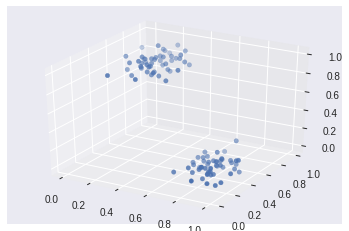

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

data = make_blobs(n_samples=100, n_features=3, centers=2, random_state=101)

features = data[0]
labels = data[1]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

data_x = scaled_data[:,0]
data_y = scaled_data[:,1]
data_z = scaled_data[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_x, data_y, data_z)

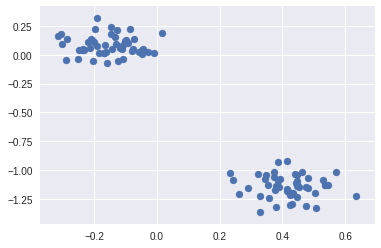

In [8]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

tf.reset_default_graph()

num_inputs = 3
num_hidden = 2
num_outputs = num_inputs

learning_rate = 0.01
epochs = 1000

X = tf.placeholder(tf.float32, shape=[None, num_inputs])
hidden = fully_connected(X, num_hidden, activation_fn=None)
outputs = fully_connected(hidden, num_outputs, activation_fn=None)

loss = tf.reduce_mean(tf.square(outputs-X))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  
  for i in range(epochs):
    sess.run(train, feed_dict={X:scaled_data})
    
  output_2d = hidden.eval(feed_dict={X:scaled_data})
  
plt.scatter(output_2d[:,0], output_2d[:,1])

# Dimensionality Reduction for 30 Dimensions

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

tf.reset_default_graph()
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

df = pd.read_csv('anonymized_data.csv')

X = df.drop('Label', 1).as_matrix()
y = df['Label'].as_matrix()

scaler = MinMaxScaler()
features = scaler.fit_transform(X)
labels = y

num_inputs = 30
num_hidden = 2
num_outputs = num_inputs

learning_rate = 0.01
epochs = 1000

X = tf.placeholder(tf.float32, shape=[None, num_inputs])
hidden = fully_connected(X, num_hidden, activation_fn=None)
outputs = fully_connected(hidden, num_outputs, activation_fn=None)

loss = tf.reduce_mean(tf.square(outputs-X))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for i in range(epochs):
        sess.run(train, feed_dict={X:features})

    output_2d = hidden.eval(feed_dict={X:features})

plt.scatter(output_2d[:,0], output_2d[:,1])


# Stacked Autoencoder

In [15]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mnist = input_data.read_data_sets('', one_hot=True)

tf.reset_default_graph()

num_inputs = 784
neurons_hidden_1 = 392
neurons_hidden_2 = 196
neurons_hidden_3 = neurons_hidden_1
num_outputs = num_inputs

actf = tf.nn.relu

X = tf.placeholder(tf.float32, shape=[None, num_inputs])
initializer = tf.variance_scaling_initializer() # initialize based on width of each layer ie:784, 392...

w1 = tf.Variable(initializer([num_inputs, neurons_hidden_1]), dtype=tf.float32)
w2 = tf.Variable(initializer([neurons_hidden_1, neurons_hidden_2]), dtype=tf.float32)
w3 = tf.Variable(initializer([neurons_hidden_2, neurons_hidden_3]), dtype=tf.float32)
w4 = tf.Variable(initializer([neurons_hidden_3, num_outputs]), dtype=tf.float32)

b1 = tf.Variable(tf.zeros(neurons_hidden_1))
b2 = tf.Variable(tf.zeros(neurons_hidden_2))
b3 = tf.Variable(tf.zeros(neurons_hidden_3))
b4 = tf.Variable(tf.zeros(num_outputs))

l1 = actf(tf.matmul(X,w1)+b1)
l2 = actf(tf.matmul(l1,w2)+b2)
l3 = actf(tf.matmul(l2,w3)+b3)
output_layer = actf(tf.matmul(l3,w4)+b4)

loss = tf.reduce_mean(tf.square(output_layer - X))
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

num_epochs = 5
batch_size = 150

saver = tf.train.Saver()

with tf.Session() as sess:
  
  sess.run(init)
  
  for epoch in range(num_epochs):
    
    num_batches = mnist.train.num_examples // batch_size
    
    for iteration in range(num_batches):
      
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(train, feed_dict={X:X_batch})
    
    training_loss = loss.eval(feed_dict={X:X_batch})
    
    print('Epoch {} Loss: {}'.format(epoch, training_loss))
    
  saver.save(sess, './example_stacked_autoencoder.ckpt')

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz
Epoch 0 Loss: 0.028471281752
Epoch 1 Loss: 0.0255079902709
Epoch 2 Loss: 0.024028038606
Epoch 3 Loss: 0.0230995398015
Epoch 4 Loss: 0.0239563900977


INFO:tensorflow:Restoring parameters from ./example_stacked_autoencoder.ckpt


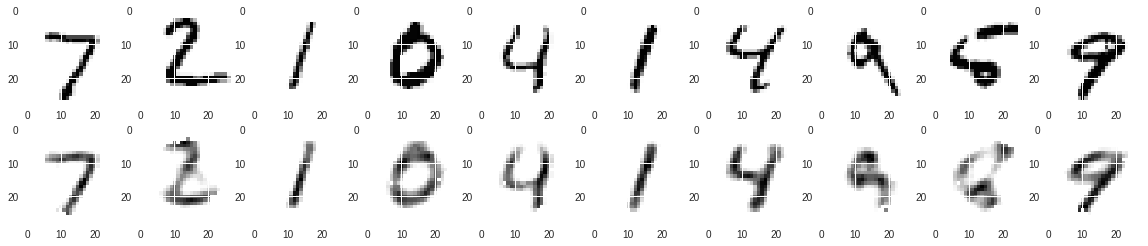

In [18]:
num_test_images = 10

with tf.Session() as sess:
  
  saver.restore(sess, './example_stacked_autoencoder.ckpt')
  results = output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]}) # evaluation can be done at any of the hidden layers
  
f, a = plt.subplots(2,10, figsize=(20,4))
for i in range(num_test_images):
  a[0][i].imshow(np.reshape(mnist.test.images[i], (28,28)))
  a[1][i].imshow(np.reshape(results[i], (28,28)))